Valores de referência:
- top-tagging: accuracy > 0.9
- quark-gluon: acc. ~ 0.8

### Importar bibliotecas

In [75]:
import pandas as pd
import numpy as np
from src.Particle import ParticleType
from src.Preprocessing import PreprocessingJetImages
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input, Conv2D, MaxPool2D #Dense = MPLNN
from keras.optimizers import Adam, schedules
from itertools import cycle

### Leitura de dados

In [3]:
data_gluon = pd.read_csv('../Dados/g_jets.csv', header=None, sep=' ')
data_quark = pd.read_csv('../Dados/q_jets.csv', header=None, sep=' ')
data_top = pd.read_csv('../Dados/t_jets.csv', header=None, sep=' ')

### Construção dos jatos e geração das imagens

In [4]:
jet_image_processing = PreprocessingJetImages(phi_range=(-0.3, 0.3), eta_range=(-0.3, 0.3), n_bins_phi=37, n_bins_eta=37)

Por se tratar de um algoritmo de top-tagging, juntamos os light quarks com os gluons em uma única categoria

In [5]:
# joinning data frames
all_jets = pd.concat([data_top, data_quark, data_gluon], axis=0)
all_jets.reset_index(drop=True, inplace=True)
# defining the dictionary with the order of jets in the full data frame
jets_order = {
    ParticleType.Top: (0, len(data_top) - 1), 
    ParticleType.Gluon: (len(data_top), len(data_top) + len(data_quark) + len(data_gluon) - 1),
}

### Particionamento dos dados

In [6]:
X = jet_image_processing.transform(X=all_jets.to_numpy(), y=jets_order)
Y = jet_image_processing.jet_labels

In [7]:
x, x_test, y, y_test = train_test_split(X, Y, train_size = 0.6, shuffle= True)
tx, vx, ty, vy = train_test_split(x_test, y_test, train_size = 0.5, shuffle= True)

x = x.reshape(-1,37,37,1)
vx = vx.reshape(-1,37,37,1)
tx = tx.reshape(-1,37,37,1)

In [35]:
#Montando a topologia da rede

nn1 = Sequential() #Rede sequencial
#especificamos as camadas da rede nn1
nn1.add(Input(shape=(37,37,1)))
nn1.add(Conv2D(filters = 128, kernel_size = (4,4),padding = 'Same', activation ='relu'))
nn1.add(Conv2D(filters = 64, kernel_size = (4,4),padding = 'Same', activation ='relu'))
nn1.add(MaxPool2D(pool_size=(2,2)))
nn1.add(Conv2D(filters = 64, kernel_size = (4,4),padding = 'Same', activation ='relu'))
nn1.add(Conv2D(filters = 64, kernel_size = (4,4),padding = 'Same', activation ='relu'))
nn1.add(MaxPool2D(pool_size=(2,2)))

# Aqui vai uma camada totalmente conectada
nn1.add(Flatten()) #Traduz uma matriz de várias dimensões em uma matriz linear (um vetor)
nn1.add(Dense(256, activation = "relu"))
nn1.add(Dense(256, activation = "relu"))
nn1.add(Dense(2, activation = "softmax"))
#topologia montada

# adicionando o otimizador
lr_schedule = schedules.ExponentialDecay(initial_learning_rate = 0.00005, decay_steps = 24650, decay_rate = 0.5, staircase = True)
optimizer = Adam(learning_rate=lr_schedule) #Adam é um backpropagation, mas com busca de mínimo otimizada

nn1.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy", "auc"]) #Avisa o keras que essa é a nossa rede

In [33]:
epochs = 50
batch_size = 128

In [36]:
treino1 = nn1.fit(x,y, epochs = epochs, validation_data = (vx, vy), batch_size = batch_size )

Epoch 1/50
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 1824s 739ms/step - accuracy: 0.8225 - auc: 0.9069 - loss: 0.3764 - val_accuracy: 0.8660 - val_auc: 0.9461 - val_loss: 0.2966
Epoch 2/50
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 1784s 723ms/step - accuracy: 0.8690 - auc: 0.9461 - loss: 0.2963 - val_accuracy: 0.8655 - val_auc: 0.9451 - val_loss: 0.2998
Epoch 3/50
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 1779s 721ms/step - accuracy: 0.8728 - auc: 0.9488 - loss: 0.2888 - val_accuracy: 0.8736 - val_auc: 0.9501 - val_loss: 0.2860
Epoch 4/50
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 1795s 728ms/step - accuracy: 0.8760 - auc: 0.9505 - loss: 0.2842 - val_accuracy: 0.8791 - val_auc: 0.9529 - val_loss: 0.2781
Epoch 5/50
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 1781s 722ms/step - accuracy: 0.8779 - auc: 0.9519 - loss: 0.2802 - val_accuracy: 0.8618 - val_auc: 0.9433 - val_loss: 0.3034
Epoch 6/50
2466/2466 ━━━━━━━━━━━━━━━━━━━━ 1778s 721ms/step - accuracy: 0.8792 - auc: 0.9531 - loss: 0.2766 - val_accuracy: 0.8796 - val_auc: 0.9537 - val_loss: 0.275

In [38]:
file = 'top-tagger.keras'
nn1.save(file)

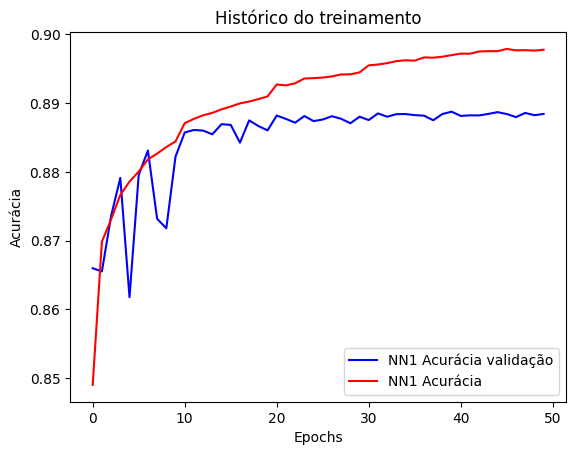

In [39]:
# Plot the loss and accuracy curves for training and validation
plt.plot(treino1.history['val_accuracy'], color='b', label="NN1 Acurácia validação")
plt.plot(treino1.history['accuracy'], color='r', label="NN1 Acurácia")
plt.title("Histórico do treinamento")
plt.xlabel("Epochs")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

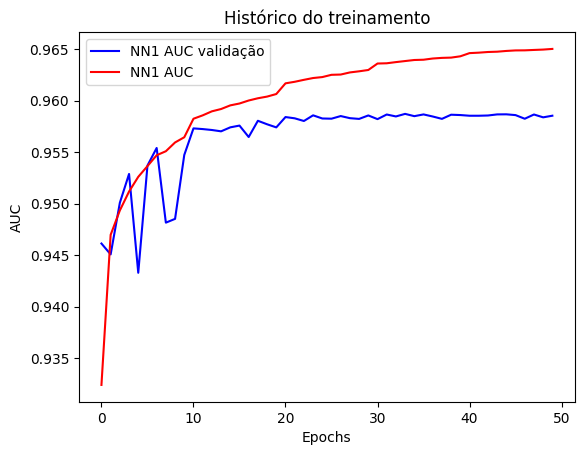

In [40]:
# Plot the AUC and accuracy curves for training and validation
plt.plot(treino1.history['val_auc'], color='b', label="NN1 AUC validação")
plt.plot(treino1.history['auc'], color='r', label="NN1 AUC")
plt.title("Histórico do treinamento")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [42]:
y_pred = nn1.predict(tx)

3287/3287 ━━━━━━━━━━━━━━━━━━━━ 171s 52ms/step


In [60]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(ty[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [68]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

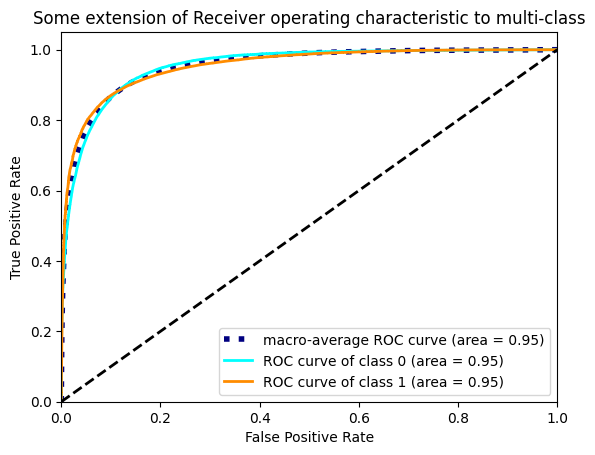

In [73]:
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [78]:
auc_sc = roc_auc_score(ty, y_pred)
auc_sc

0.9535495623346388